In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [2]:
def load_pkl(fp):
    with open(fp, 'rb') as file:
        result = pickle.load(file)
    return result

In [3]:
def weird_load(fp):
    container = {}
    with open(fp, 'rb') as file:
        while True:
            chunk = file.read(3408)
            if not chunk:
                break
            with open('_', 'wb') as temp:
                temp.write(chunk)
            data = load_pkl('_')
            container.update(data)
    return container

In [4]:
result = weird_load('outcome.pkl')

In [5]:
def to_case(result):
    outcome = defaultdict(list)
    for area in result.keys():
        case_n = area.rsplit('/', 2)[-2]
        outcome[case_n].append(area)
    return outcome

In [6]:
case_dict = to_case(result)

In [7]:
def profile_count(case_dict):
    outcome = {}
    for case_n, areas in case_dict.items():
        count = len(areas)
        outcome[case_n] = count
    return outcome

In [8]:
case_count = profile_count(case_dict)

In [9]:
def profile_threshold(case_dict, result, threshold=0.98):
    outcome = defaultdict(list)
    threshes = np.arange(0.96, 1.00, 0.01)
    thresh_temp = {thresh:defaultdict(int) for thresh in threshes}
    for case_n, areas in case_dict.items():
        for area in areas:
            p = result[area]
            loc = round(p-0.004, 2)
            if loc in thresh_temp.keys():
                thresh_temp[loc][case_n] += 1
            if p >= threshold:
                outcome[case_n].append(area)
                
    return outcome, thresh_temp

In [10]:
def refine_thresh_temp(thresh_temp, threshes, threshold):
    threshes = threshes[::-1]
    for idx, thresh in enumerate(threshes[1:], 1):
        pre_thresh = threshes[idx-1]
        pre = thresh_temp[pre_thresh]
        cur = thresh_temp[thresh]
        for case_n in cur:
            cur[case_n] += cur[case_n] + pre[case_n]
        
    for thresh, counts in thresh_temp.items():
        print(thresh, min(counts.values()), max(counts.values()))
        
    plt.hist(thresh_temp[threshold].values(), bins=50)

In [11]:
selected_area, thresh_temp = profile_threshold(case_dict, result)

0.96 94 29103
0.97 71 26193
0.98 45 22335
0.99 25 16313
1.0 1 3305


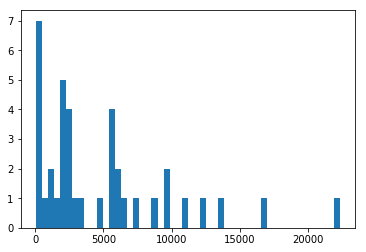

In [12]:
threshes = np.arange(0.96, 1.00, 0.01)
refine_thresh_temp(thresh_temp, threshes, 0.98)

In [13]:
lens = [len(areas) for areas in selected_area.values()]

In [14]:
max(lens)

12067

In [15]:
min(lens)

23

In [38]:
def download_fps(selected_area):
    with open('selected_area.txt', 'w+') as command:
        suffix = ';'
        line = f'mkdir ../download{suffix}'
        command.write(line)
        for case_n, areas in selected_area.items():
            case_p = f'../download/{case_n}'
            line = f'mkdir {case_p}{suffix}'
            command.write(line)
            for area in areas:
                line = f'mv {area} {case_p}/{suffix}'
                command.write(line)

In [39]:
download_fps(selected_area)

In [40]:
with open ('selected_area.txt', 'r') as new:
    line = new.read(300)
print(line)

mkdir ../download;mkdir ../download/TCGA-D8-A1X7-01Z-00-DX1.3529AEED-2827-4D94-9A8B-32F116EE49D5;mv ../tiff/TCGA-D8-A1X7-01Z-00-DX1.3529AEED-2827-4D94-9A8B-32F116EE49D5/00000000720000000010.tiff ../download/TCGA-D8-A1X7-01Z-00-DX1.3529AEED-2827-4D94-9A8B-32F116EE49D5/;mv ../tiff/TCGA-D8-A1X7-01Z-00-


In [71]:
sns.set()

In [199]:
cases = set(case_dict.keys())

In [201]:
with open('done.pkl', 'wb') as done:
    pickle.dump(cases, done, pickle.HIGHEST_PROTOCOL)